# **Random Forest Regressor and XAI**

The aim of the script is to model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A), Sentinel-2 (S2), Normalized Difference Vegetation Index (NDVI), Canopy Chlorophyll Content Index (CCCI), Specific Leaf Area Vegetation Index (SLAVI), and a random forest model.

Then we conduct XAI.Actually Explainable machine learning (ML) methods are essential for interpreting the decision-making processes of complex or “black-box” models. These methods aim to reveal which input features most significantly influence model predictions, thereby improving transparency and trust in ML outcomes.

We will model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A), Sentinel-2 (S2), Normalized Difference Vegetation Index (NDVI), Canopy Chlorophyll Content Index (CCCI), Specific Leaf Area Vegetation Index (SLAVI), and a random forest model. We also employ SHAP (Shapley Additive exPlanations), and surrogate models to gain insights in the random forest model.



## Install Libraries

Install the necessary libraries.

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00


Next, import the following libraries.

In [ ]:
# Import the libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
import earthpy.plot as ep
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import shap
from sklearn.inspection import permutation_importance # PFI - Permutation Feature Importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
import seaborn as sns
import joblib # Import joblib library

# Setting-up Colab
## Mount your Google Drive
First, make sure that your data is loaded in Google Drive. After that mount your Google Drive using the code below.

In [ ]:
# Import the neccessary library
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access the raster and vector datasets
Import the raster  and vector datasets. Prepare the features and labels.

In [ ]:
# Prepare the parameters
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI','CCCI','SLAVI']
LABEL = ['agbd_mean'] # Target variable
SAMPLE_PATH = '/content/drive/My Drive/DPZ_Datasets/DPZ_Training_Data_2022.csv' # With filtered agbd
IMAGE_PATH = '/content/drive/My Drive/DPZ_Datasets/DPZ_prs_S2_VI_2022.tif'

## Create image composites
Load and display the imagery.

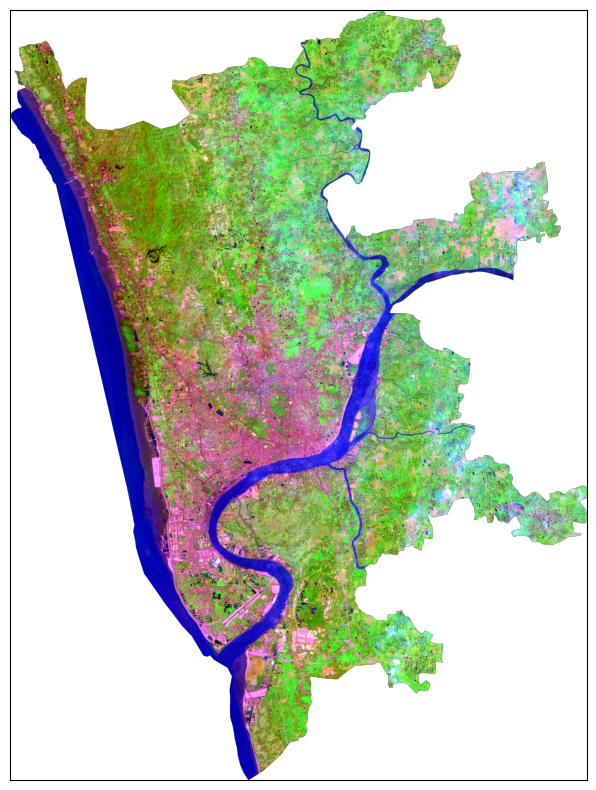

<Axes: >

In [ ]:
# Load the image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [9, 7, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (10, 10)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Prepare datasets for modeling
## Import the sample data

Next, we are going to load the sample data with the aboveground biomass density (AGBD) and raster variables.

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)[FEATURES + LABEL]
samples

,B2,B3,B4,B5,B6,B7,B8,B11,B12,NDVI,CCCI,SLAVI,agbd_mean
0,0.510098,0.488979,0.469468,0.488979,0.552811,0.582924,0.573498,0.613922,0.524881,0.598762,0.544176,0.775322,12.696663
1,0.497996,0.483218,0.459891,0.477074,0.554076,0.595399,0.593212,0.554527,0.475710,0.624601,0.608613,0.839017,27.002604
2,0.513323,0.499199,0.501498,0.505470,0.569298,0.589406,0.573672,0.591101,0.521632,0.566827,0.547405,0.773839,30.298262
3,0.513712,0.494166,0.471063,0.477179,0.541479,0.568419,0.558480,0.534883,0.462277,0.584301,0.593417,0.806988,30.298262
4,0.500799,0.479687,0.463033,0.478017,0.562050,0.597244,0.585320,0.550818,0.465725,0.615081,0.612332,0.830823,30.298262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,0.491935,0.470425,0.445646,0.458912,0.521344,0.550999,0.530943,0.503885,0.419166,0.586681,0.616040,0.811492,216.655609
1844,0.495076,0.481975,0.465618,0.505173,0.560179,0.589067,0.565066,0.591101,0.512055,0.595598,0.549097,0.781967,216.719879
1845,0.485180,0.467119,0.443734,0.463249,0.538702,0.570614,0.562939,0.497293,0.418450,0.616777,0.644106,0.856709,218.226959
1846,0.485180,0.467119,0.443734,0.463249,0.538702,0.570614,0.562939,0.497293,0.418450,0.616777,0.644106,0.856709,218.226959


## Split training data
First, let's split the training points into training and test datasets.

In [ ]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

# Get variables input and output
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[LABEL].astype(float)
y_test = test[LABEL].astype(float)

# Show the data shape
print(f'Train features: {X_train.shape}\nTest features: {X_test.shape}\nTrain label: {y_train.shape}\nTest label: {y_test.shape}')

Train features: (1478, 12)
Test features: (370, 12)
Train label: (1478, 1)
Test label: (370, 1)


## Perform exploratory data analysis (EDA)
Exploratory data analysis (EDA) is an important step in understanding your data before building a machine learning model. To perform EDA on your training dataset, we will use libraries such as pandas for data manipulation and matplotlib or seaborn for data visualization. First, we will start by creating a DataFrame for the training dataset.

In [ ]:
# Create a DataFrame from X_train and y_train
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'Band_{i}' for i in range(X_train.shape[1])] + ['agbd'])

# Rename columns in the DataFrame train_df
train_df.columns = FEATURES + ['agbd']

We will take a quick look at the top five rows using the DataFrame's head() method.

In [ ]:
# Check the first five rows
train_df.head()

,B2,B3,B4,B5,B6,B7,B8,B11,B12,NDVI,CCCI,SLAVI,agbd
0,0.512933,0.486210,0.457930,0.475395,0.562139,0.591101,0.577062,0.541849,0.431277,0.613599,0.641618,0.830817,102.425529
1,0.492697,0.475920,0.465833,0.480781,0.525690,0.552087,0.536470,0.571489,0.495278,0.570127,0.539861,0.764717,50.398624
2,0.511371,0.490306,0.459619,0.478487,0.584166,0.629603,0.619839,0.519471,0.437207,0.645226,0.667767,0.899293,60.853119
3,0.492138,0.476235,0.450555,0.470213,0.553805,0.592959,0.581550,0.541110,0.443959,0.624908,0.631795,0.841065,45.340866
4,0.509166,0.491732,0.470425,0.479948,0.557584,0.593422,0.567054,0.538191,0.456782,0.592337,0.606469,0.814659,44.851959


Let's use the info() method to get a quick description of the data.

In [ ]:
# Use the info()to check the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B2      1478 non-null   float64
 1   B3      1478 non-null   float64
 2   B4      1478 non-null   float64
 3   B5      1478 non-null   float64
 4   B6      1478 non-null   float64
 5   B7      1478 non-null   float64
 6   B8      1478 non-null   float64
 7   B11     1478 non-null   float64
 8   B12     1478 non-null   float64
 9   NDVI    1478 non-null   float64
 10  CCCI    1478 non-null   float64
 11  SLAVI   1478 non-null   float64
 12  agbd    1478 non-null   float64
dtypes: float64(13)
memory usage: 150.2 KB


Next, we will use the describe() method to get summary statistics of the training dataset. This will provide statistics such as mean, standard deviation, minimum, maximum, and quartiles for each feature and the target variable.

In [ ]:
# Print summary statistics
summary_stats = train_df.describe()
print(summary_stats)

                B2           B3           B4           B5           B6  \
count  1478.000000  1478.000000  1478.000000  1478.000000  1478.000000   
mean      0.501690     0.484107     0.460858     0.478375     0.559570   
std       0.014057     0.014078     0.017466     0.014876     0.021902   
min       0.477912     0.460217     0.435086     0.453431     0.473814   
25%       0.491121     0.473458     0.448888     0.468402     0.544357   
50%       0.496991     0.480000     0.457602     0.475815     0.559017   
75%       0.511261     0.492747     0.467814     0.484536     0.573847   
max       0.563205     0.555338     0.574630     0.574978     0.622254   

                B7           B8          B11          B12         NDVI  \
count  1478.000000  1478.000000  1478.000000  1478.000000  1478.000000   
mean      0.595843     0.581291     0.534221     0.452113     0.613458   
std       0.027953     0.028672     0.029231     0.031681     0.026861   
min       0.498799     0.473814     0

We will visualize the distribution and potential outliers of each feature using boxplots. This code will generate a boxplot for each feature, showing the median, quartiles, and any potential outliers.

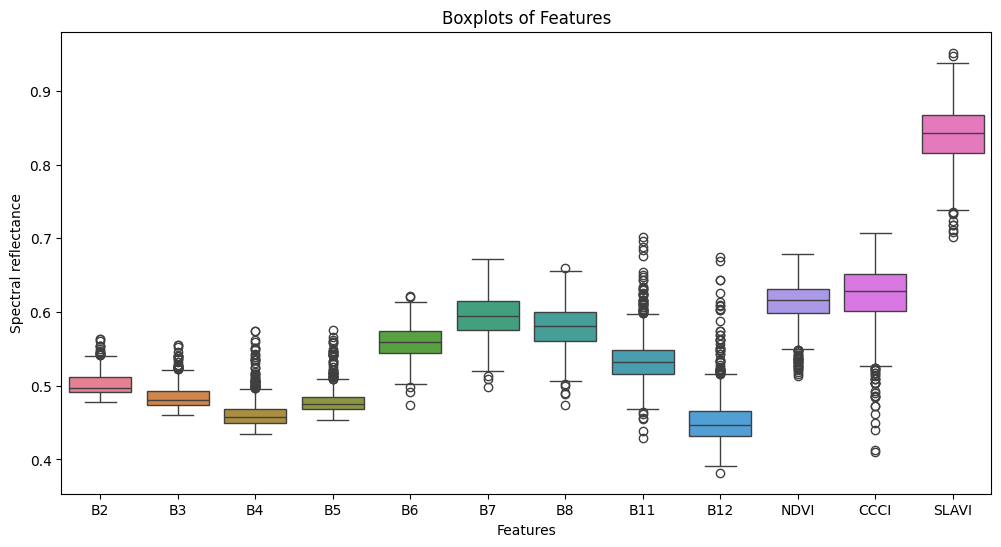

In [ ]:
# Import the seaborn library
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))

# Create boxplots for each feature
sns.boxplot(data=train_df.drop(columns=['agbd']), orient='v')
plt.title('Boxplots of Features')
plt.xlabel('Features')
plt.ylabel('Spectral reflectance')
plt.show()

# Select and Train a Model Training
## Training a random forest regression model
We will start with a random forest regression model. Note that 'y_train' is now a column-vector. Therefore, we will use the ravel() function to change the shape of the target variable 'y_train' from a column-vector to a 1D array. In scikit-learn's RandomForestRegressor, the target variable y is expected to be a 1D.

The ravel() function is a method in NumPy, a popular numerical computing library in Python. It is used to flatten multi-dimensional arrays into a 1D array. When applied to a NumPy array, the ravel() function returns a contiguous flattened array containing the same elements as the input array.

We will tune the hyperparameters of the RF model. Parameters like n_estimators, max_depth, and min_samples_split can significantly impact the model's performance. We will use techniques like grid search or random search to find the optimal set of hyperparameters.

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best parameters
best_params = grid_search.best_params_

Next, we will use the best parameters obtained from the grid search to train the final RF regression model (RandomForestRegressor).

In [ ]:
# Use the best parameters from the grid search
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

# Initialize the RandomForestRegressor with the best parameters
best_rf_reg = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split
)

# Fit the model to the training data
best_rf_model = best_rf_reg.fit(X_train, y_train.values.ravel())

Next, we will use K-fold cross validation feature to split the training data into 10 subsets called folds. Then print the RMSE scores.

In [ ]:
# Calculate the RF model RMSE using cross-validation
neg_mse_scores = cross_val_score(best_rf_model, X_train, y_train.values.ravel(),
                                 scoring="neg_mean_squared_error", cv=10)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-neg_mse_scores)

# Print or use the RMSE scores
print("RMSE Scores:", rmse_scores)

RMSE Scores: [32.98375517 34.21554886 38.26946477 38.39439414 37.226132   29.4885361
 35.01338589 39.66842928 34.14547679 33.57480402]


Let's create a scatter plot for the RF model.


Mean Bias Error (MBE): 2.267080156874786
Root Mean Square Error (RMSE): 36.30741511011404
R-squared (R2): 0.15886816773717805


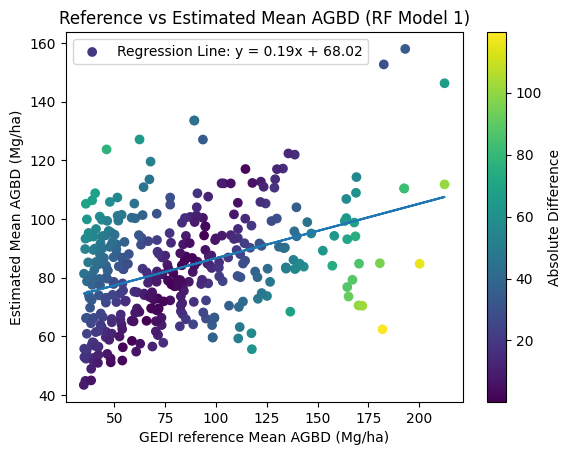

In [ ]:
# Predict test data
rf_prediction = best_rf_model.predict(X_test).flatten()
label = y_test.values.flatten()

# Calculate MBE
mbe = np.mean(rf_prediction - label)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(label, rf_prediction))

# Calculate R2
r2 = r2_score(label, rf_prediction)

print(f'Mean Bias Error (MBE): {mbe}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Calculate the absolute difference between predicted and actual values
absolute_diff = np.abs(rf_prediction - label)

# Plot the scatter plot with colors based on the absolute difference
plt.scatter(label, rf_prediction, c=absolute_diff, cmap='viridis')
m, b = np.polyfit(label, rf_prediction, 1)
plt.plot(label, m * label + b)
plt.title('Reference vs Estimated Mean AGBD (RF Model 1)')
plt.xlabel('GEDI reference Mean AGBD (Mg/ha)')
plt.ylabel('Estimated Mean AGBD (Mg/ha)')
plt.colorbar(label='Absolute Difference')  # Adding a colorbar for reference
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])

plt.show()

## Save the Best RF Model
Let's save the best RF model parameters, feature names, or other metadata together.

In [ ]:
# joblib library or module.
import joblib

# Save the model
MODEL_PATH = '/content/drive/MyDrive/DPZ_Datasets/best_rf_model.pkl'

model_package = {
    "model": best_rf_model,
    "features": FEATURES,
    "label": LABEL
}
joblib.dump(model_package, MODEL_PATH)

# Load with:
package = joblib.load(MODEL_PATH)
loaded_model = package["model"]

## Predict and display agbd map
Next, we will predict and display agbd map. Note that the final agbd image map will be exported as a GeoTIFF file, which can be visualized in any GIS software.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


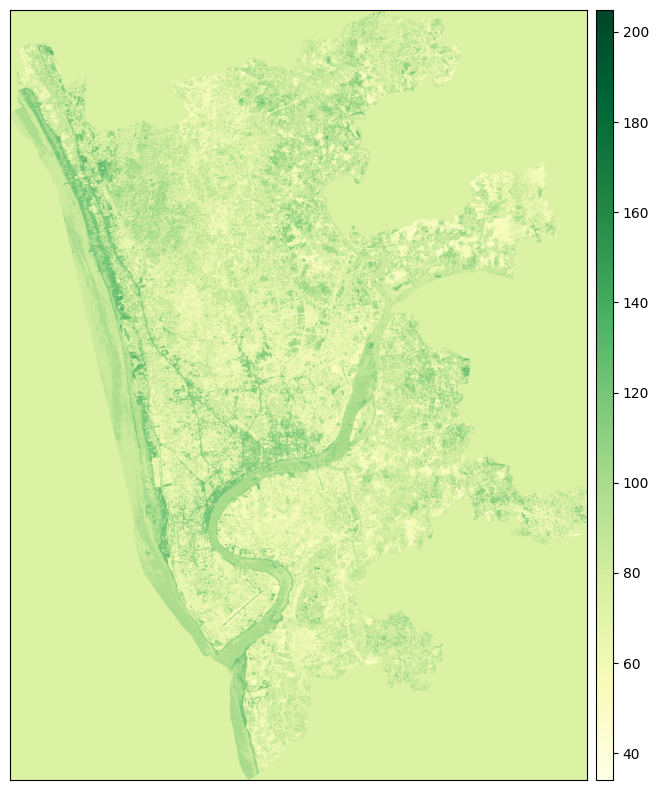

<Axes: >

In [ ]:
# Read all 12 bands from the image (assuming 12-band image)
image_input = []
for x in range(12):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(12, -1).T  # shape: (pixels, features)

# Predict using the trained Random Forest model
rf_prediction = best_rf_model.predict(image_input)

# Reshape prediction to 2D image
rf_prediction = rf_prediction.reshape(shape[0], shape[1])

# Visualize the predicted raster
ep.plot_bands(rf_prediction, cmap='YlGn', figsize=plot_size)

Save the predicted AGBD map from the RF model as geotiff.

In [ ]:
# Save file to drive
save_location = '/content/drive/My Drive/DPZ_Datasets/'
name = 'RF_Model_AGBD_2021a.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = rf_prediction.shape[0], width = rf_prediction.shape[1],
      count=1, dtype=str(rf_prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(rf_prediction, 1);
new_dataset.close()

# **Perform XAI**

We will use Explainable Machine Learning (xML) methods such as SHAP (Shapley Additive exPlanations) and surrogate models to gain insights in the random forest model. These approaches provide valuable insights into the inner workings of various machine learning models, making them versatile tools for comprehending these models.

Let's start by loading and extracting the saved random forest model from the dictionary.

In [ ]:
# Define the target and predictor variables
LABEL = ['agbd_mean'] # target variable
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI','CCCI','SLAVI'] # predictor variables
SAMPLE_PATH = '/content/drive/My Drive/DPZ_Datasets/DPZ_Training_Data_2022.csv' # With filtered agbd
IMAGE_PATH = '/content/drive/My Drive/DPZ_Datasets/DPZ_prs_S2_VI_2022.tif'
MODEL_PATH = '/content/drive/MyDrive/DPZ_Datasets/best_rf_model.pkl' # Define model path

In [ ]:
# Load the dictionary
model_package = joblib.load(MODEL_PATH)

# Extract the actual Random Forest model
loaded_rf_model = model_package["model"]

# **Feature importance**
Let's start by examing varaiable importance. Feature importance methods highlight the contribution of each input variable to the model’s prediction.

# **Mean Decrease Impurity (MDI)**
The MDI, used in tree-based models like random forests, evaluates feature importance by measuring the reduction in impurity (e.g., Gini index) caused by each feature. While it is efficient and embedded in model training, it is biased toward features with many categories. PFI, a model-agnostic method, measures the increase in prediction error when a feature’s values are randomly shuffled. It provides an intuitive link between feature importance and model accuracy but is computationally intensive and sensitive to randomness.

/tmp/ipython-input-1561681575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=mdi_df, palette='viridis')


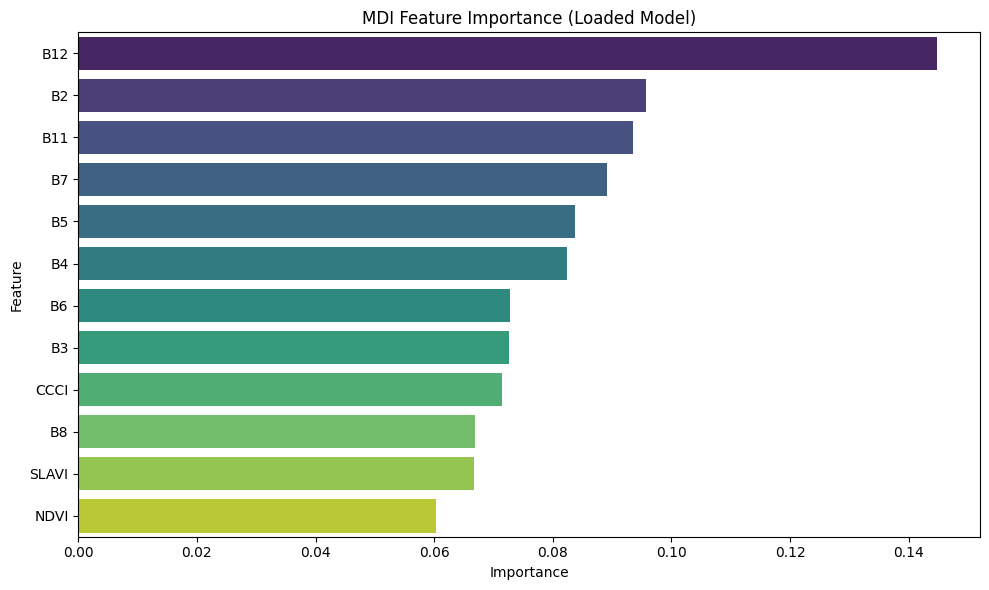

In [ ]:
# MDI - Mean Decrease Impurity from the loaded model
mdi_importances = loaded_rf_model.feature_importances_

# Create DataFrame for plotting
mdi_df = pd.DataFrame({'Feature': FEATURES, 'Importance': mdi_importances})
mdi_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mdi_df, palette='viridis')
plt.title('MDI Feature Importance (Loaded Model)')
plt.tight_layout()
plt.show()

# **SHAP (SHapley Additive exPlanations) method**
Next, we will use the SHAP method. The SHAP (SHapley Additive exPlanations) method is based on the shapley values, which is a concept from cooperative game theory proposed by Lloyd Shapley (1953). It has been adapted for machine learning model interpretability. In the context of explainable machine learning (xML), shapley values quantify the contribution of each feature to a specific prediction by averaging the marginal contributions it makes when combined with all possible subsets of features. In other words, Shapley Values provide a fair allocation of the "credit" for a prediction among the different features. They offer a holistic understanding of feature importance in machine learning models. To use SHAP in combination with the RandomForestRegressor, we can leverage the shap library in Python.

Let's create an explainer for the RF model. Explainer prints useful information, especially for resolving potential errors.

In [ ]:
# Now you can use SHAP with the loaded model
explainer = shap.Explainer(loaded_rf_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

 99%|===================| 1470/1478 [02:42<00:00]       

# **Create a beeswarm plot**
Note that the feature importance only shows the magnitude of the contribution of each predictor variable (band). How, it does not show the direction (negative or positive) of each predictor variable to the model.

Next, let's display them using the beeswarm plot. Keep in mind that Shap explanations are approximations and might not perfectly capture the full complexity of the RF model. However, they can be very useful for gaining insights into understanding feature contributions.

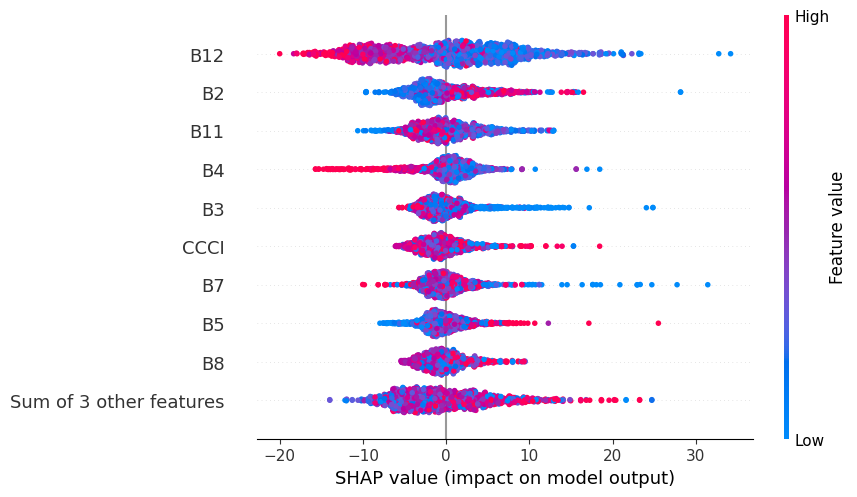

In [ ]:
# Visualize
shap.plots.beeswarm(shap_values)

The SHAP beeswarm plot illustrates the relative importance and directional influence of input features on the Random Forest model’s AGBD predictions. Features are ordered from top to bottom according to their overall contribution, with B12 (SWIR-2) emerging as the most influential variable, followed by B2 (Blue) and B11 (SWIR-1). The horizontal spread of points reflects the magnitude of each feature’s impact on model output, while color gradients indicate feature values, with blue representing low values and red representing high values.

High values of B12 and B11 predominantly contribute to negative SHAP values, indicating that increased SWIR reflectance—often associated with moisture stress or sparse vegetation—leads to lower predicted biomass. In contrast, lower SWIR values tend to increase AGBD estimates, highlighting the sensitivity of the model to canopy water content and forest structure. Visible bands (B2, B3, and B4) show mixed effects, where higher reflectance generally corresponds to reduced biomass predictions, likely reflecting increased soil or non-vegetated surface exposure.

Vegetation-related features such as CCCI exhibit a clearer positive relationship, with higher index values contributing positively to AGBD estimates, consistent with increased chlorophyll concentration and canopy density. Red-edge and NIR bands (B5, B7, and B8) show moderate but consistent contributions, suggesting their role in capturing vegetation vigor and structural variability. The combined influence of lower-ranked variables, represented as the sum of three other features, indicates that while individually weak, their cumulative effect still contributes meaningfully to the model.

Overall, the beeswarm plot reveals that the model relies strongly on SWIR and visible spectral information, while vegetation indices and red-edge bands provide complementary structural insights. However, the wide dispersion of SHAP values, particularly for high-impact features, also reflects model uncertainty and nonlinear interactions, which may partly explain the observed underestimation of high AGBD values in dense forest conditions.

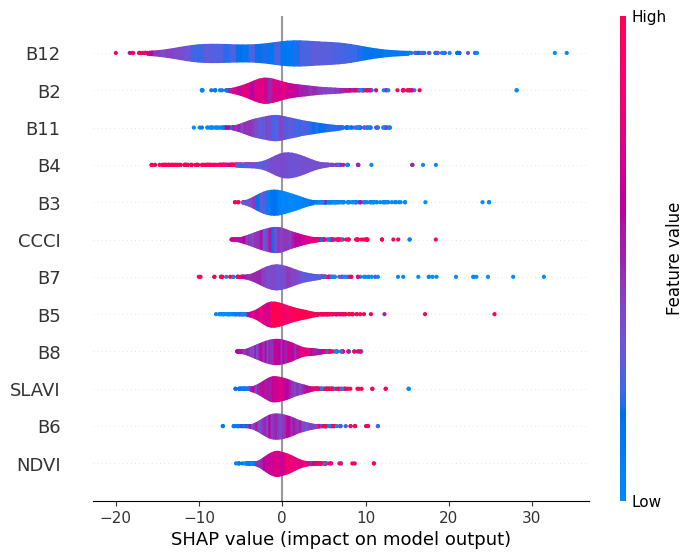

In [ ]:
# Create a Layered plot
# Layered violin plot
shap.plots.violin(shap_values, max_display=12)

# **Surrogate Decision Tree Model**
Next, we wiil use the 'model_surrogate' function to create Global Surrogate models for the RF model. We will use the DecisionTreeRegressor to fit the models. The resulting models can be used to explore and explain the behavior of the original RF model. This can be helpful in understanding complex models and their predictions.

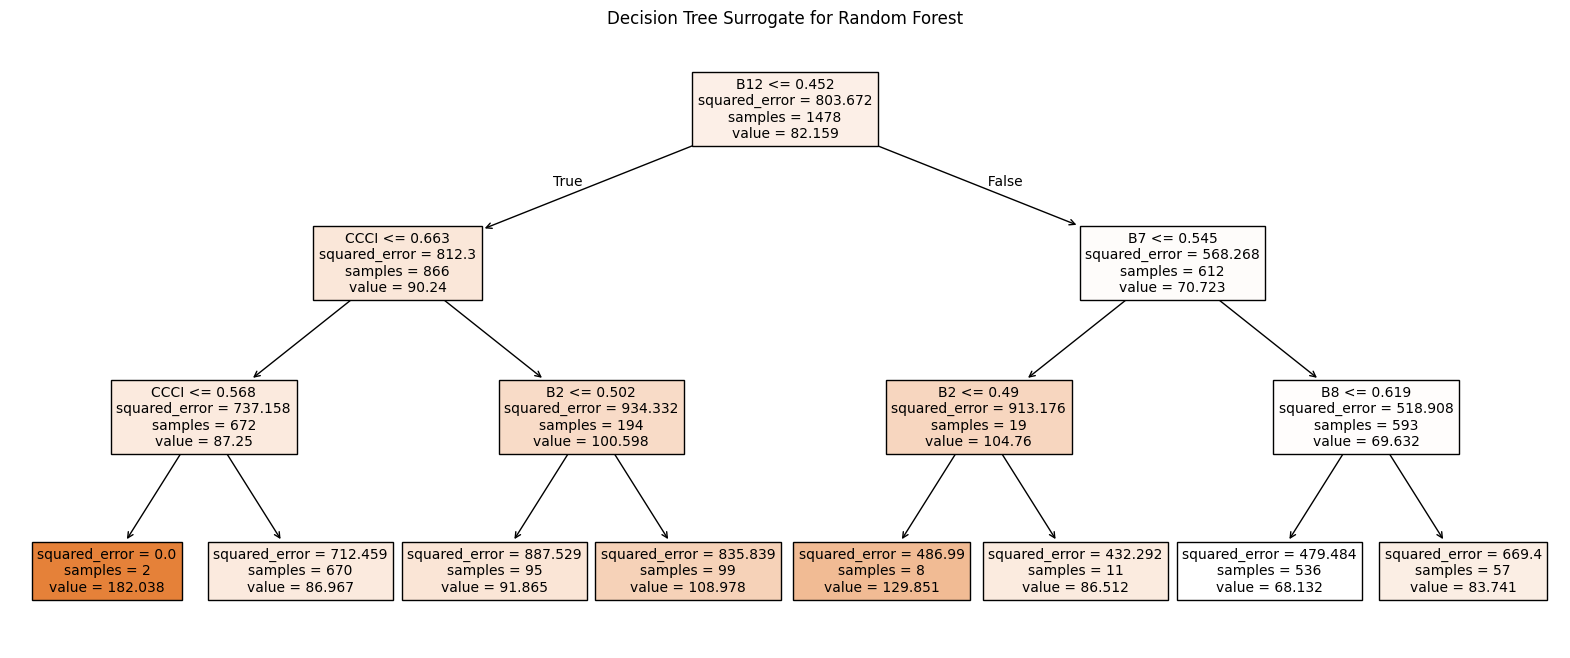

In [ ]:
# Import sklearn decision tree regressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Step 1: Get predictions from the loaded RF model
y_train_pred = loaded_rf_model.predict(X_train)

# Step 2: Train a surrogate Decision Tree
surrogate = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate.fit(X_train, y_train_pred)

# Step 3: Plot the surrogate decision tree
plt.figure(figsize=(20, 8))
plot_tree(surrogate, feature_names=FEATURES, filled=True, fontsize=10)
plt.title('Decision Tree Surrogate for Random Forest')
plt.show()